# Table of contents:
### 1. Loading and checking the data
- Checking the data for timestamp gaps or missing data.
### 2. Visualisations and statistical testing
- Comparing the AC and DC power outputs in generators 1 and 2,
- Comparing the ambient and module temperature, and irradiation in sensors 1 and 2.
### 3. Performance Evaluation
- Conversion efficiency and performance ratio
### 4. Forecast
### 4a. Using Seasonal ARIMA
### 4b. Using XGBoost
- Predicting DC Power output from inputs Time, Module Temperature, Irradiation.
- Forecasting the next 7 days.

# Setting Up

## Load packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import xgboost as xgb

from pathlib import Path

data_path = Path('/Users/madelinelui/Documents/photovoltaics-analysis/pv-panels-india/')
# conda activate pv-panels

## Functions

In [6]:
# ------------------ Functions -------------------- #

# split train-test data at a certain date
def train_test_split(data, ratio):
    nrow = len(data.index)
    print('Total records: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training records: ',split_row)
    print('Testing records: ',nrow-split_row)
    train = data.iloc[:split_row]
    test = data.iloc[split_row:]
    return train, test, split_row

# Create future forecast dates, with 15 minute intervals.
def create_dates(days):
    # there are 96 intervals of 15 minutes per day
    # normalize = True starts/ends time at midnight
    v = pd.date_range(start=pd.to_datetime('2020-06-18'), periods = days*96, freq='15min', normalize = True)
    created_dates = pd.DataFrame({'DATE_TIME': v}, index=np.arange(len(v))) 
    return created_dates

# Create lagged features for forecasting
def create_lag_features(testing_and_forecast):
    forecast_lag_var = testing_and_forecast.copy()
    forecast_lag_var['MODULE_TEMPERATURE'] = testing_and_forecast['MODULE_TEMPERATURE'].shift(672)
    forecast_lag_var['IRRADIATION'] = testing_and_forecast['IRRADIATION'].shift(672)
    forecast_lag_var = forecast_lag_var.drop(['DC_POWER'], axis=1)
    forecast_lag_var = forecast_lag_var.iloc[3259:3931]
    return forecast_lag_var

## Load Data

In [7]:
# ----------------- Load Data ------------------ #
## Power Generation datasets
gen1 = pd.read_csv(data_path / 'Plant_1_Generation_Data.csv')
gen1.head()
gen2 = pd.read_csv(data_path / 'Plant_2_Generation_Data.csv')
gen2.head()

## Weather Sensor datasets
sen1 = pd.read_csv(data_path / 'Plant_1_Weather_Sensor_Data.csv')
sen1.head()
sen2 = pd.read_csv(data_path / 'Plant_2_Weather_Sensor_Data.csv')
sen2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


# Exploration Analysis

In [8]:
# --------------------- Exploration Analysis ---------------------- #

# --- Check Gaps in Data --- #

# Parse Date-time
gen1['DATE_TIME'] = pd.to_datetime(gen1['DATE_TIME'], format = '%d-%m-%Y %H:%M')
gen2['DATE_TIME'] = pd.to_datetime(gen2['DATE_TIME'], format = '%Y-%m-%d %H:%M:%S')
sen1['DATE_TIME'] = pd.to_datetime(sen1['DATE_TIME'], format = '%Y-%m-%d %H:%M:%S')
sen2['DATE_TIME'] = pd.to_datetime(sen2['DATE_TIME'], format = '%Y-%m-%d %H:%M:%S')

# recode plant ID to 1 and 2
# use groupby().sum() to combine measures under the same time entry 
gen1_idx = gen1.groupby('DATE_TIME').sum().reset_index()
gen1_idx["PLANT_ID"]= 1
gen2_idx = gen2.groupby('DATE_TIME').sum().reset_index()
gen2_idx["PLANT_ID"]= 2

# what this did is shorten the DFs of gen1 and gen2.

sen1['PLANT_ID'] = 1
sen2['PLANT_ID'] = 2

# check if there are gaps in the timestamps
deltas_g1 = gen1_idx['DATE_TIME'].diff()

# Filter diffs
gaps_g1 = deltas_g1[deltas_g1 > timedelta(minutes=15)]
print(f'In gen1 there are {len(gaps_g1)} gaps, with minimum {gaps_g1.min()} and maximum {gaps_g1.max()}.')

deltas_g2 = gen2_idx['DATE_TIME'].diff()[1:]
gaps_g2 = deltas_g2[deltas_g2 > timedelta(minutes=15)]
print(f'In gen2 there are {len(gaps_g2)} gaps, with minimum {gaps_g2.min()} and maximum {gaps_g2.max()}.')

deltas_s1 = sen1['DATE_TIME'].diff()[1:]
gaps_s1 = deltas_s1[deltas_s1 > timedelta(minutes=15)]
print(f'In sensor 1 there are {len(gaps_s1)} gaps, with minimum {gaps_s1.min()} and maximum {gaps_s1.max()}.')

deltas_s2 = sen2['DATE_TIME'].diff()[1:]
gaps_s2 = deltas_s2[deltas_s2 > timedelta(minutes=15)]
print(f'In sensor 2 there are {len(gaps_s2)} gaps, with minimum {gaps_s2.min()} and maximum {gaps_s2.max()}.')

In gen1 there are 9 gaps, with minimum 0 days 00:30:00 and maximum 0 days 09:00:00.
In gen2 there are 5 gaps, with minimum 0 days 00:30:00 and maximum 0 days 00:30:00.
In sensor 1 there are 8 gaps, with minimum 0 days 00:30:00 and maximum 0 days 07:15:00.
In sensor 2 there are 5 gaps, with minimum 0 days 00:30:00 and maximum 0 days 00:30:00.


### Visualisation

Between the DC and AC records in plant 1, there is a discrepancy in power output by a factor of 10 in DC output.


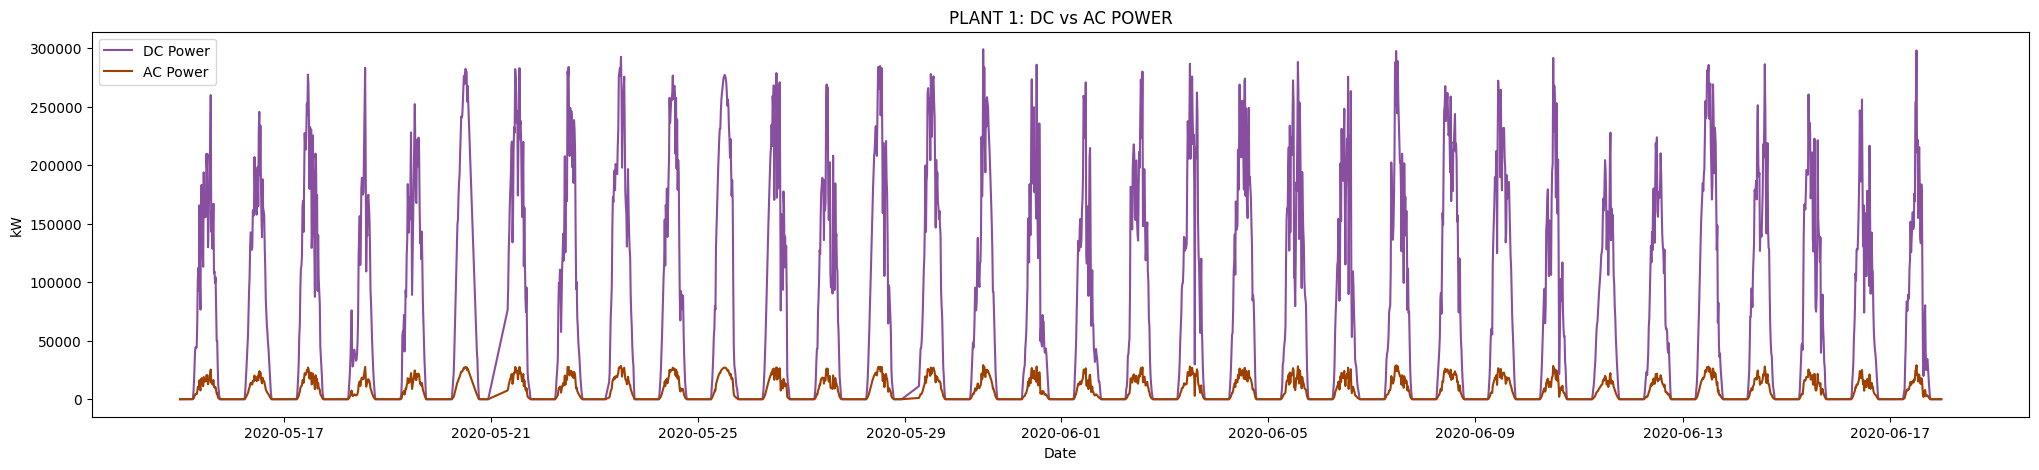

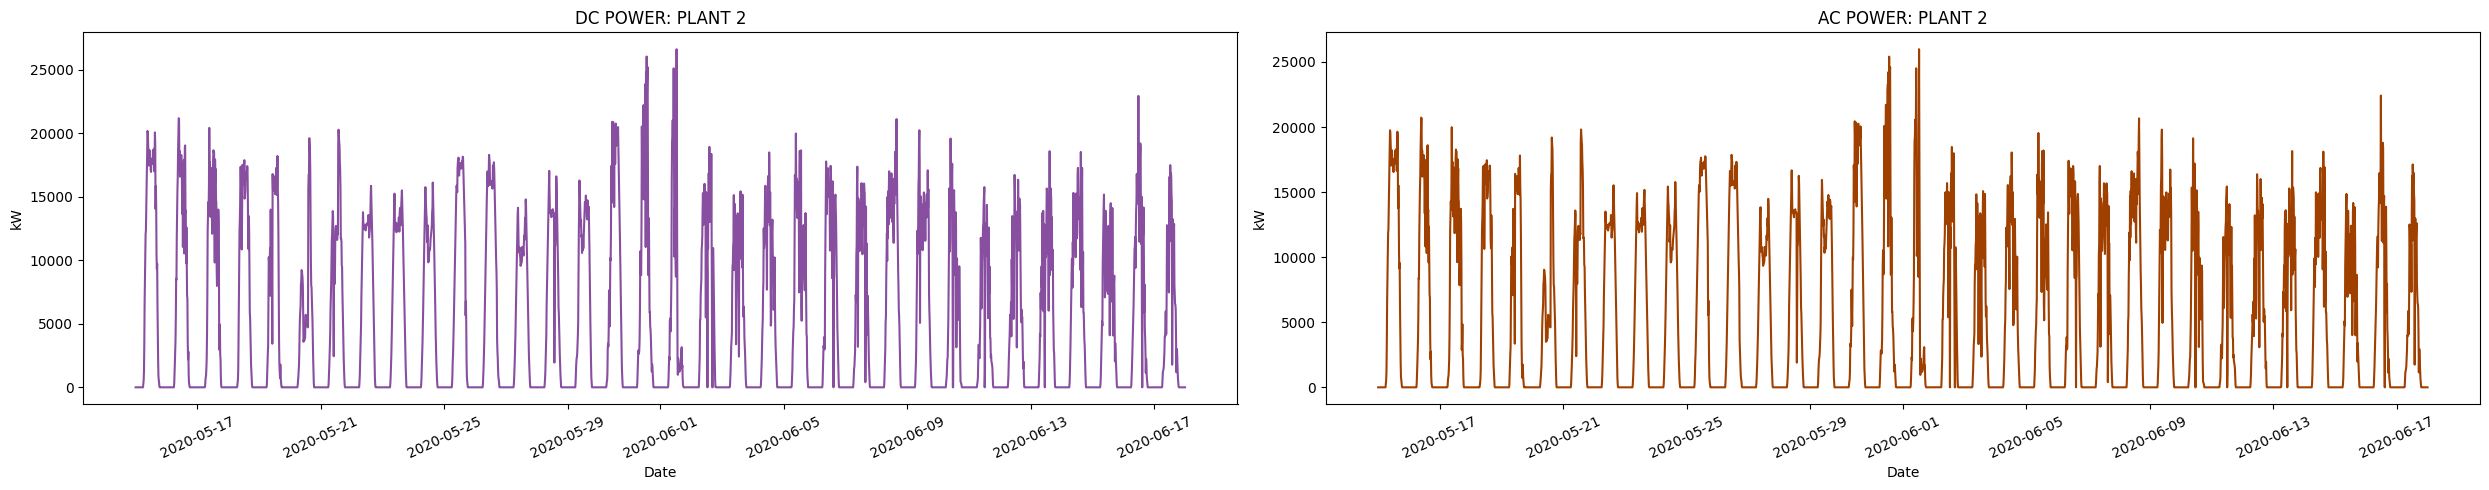

There is no discrepancy between AC and DC power outputs in Plant 2.


Text(0, 0.5, 'kWh⋅m^-2')

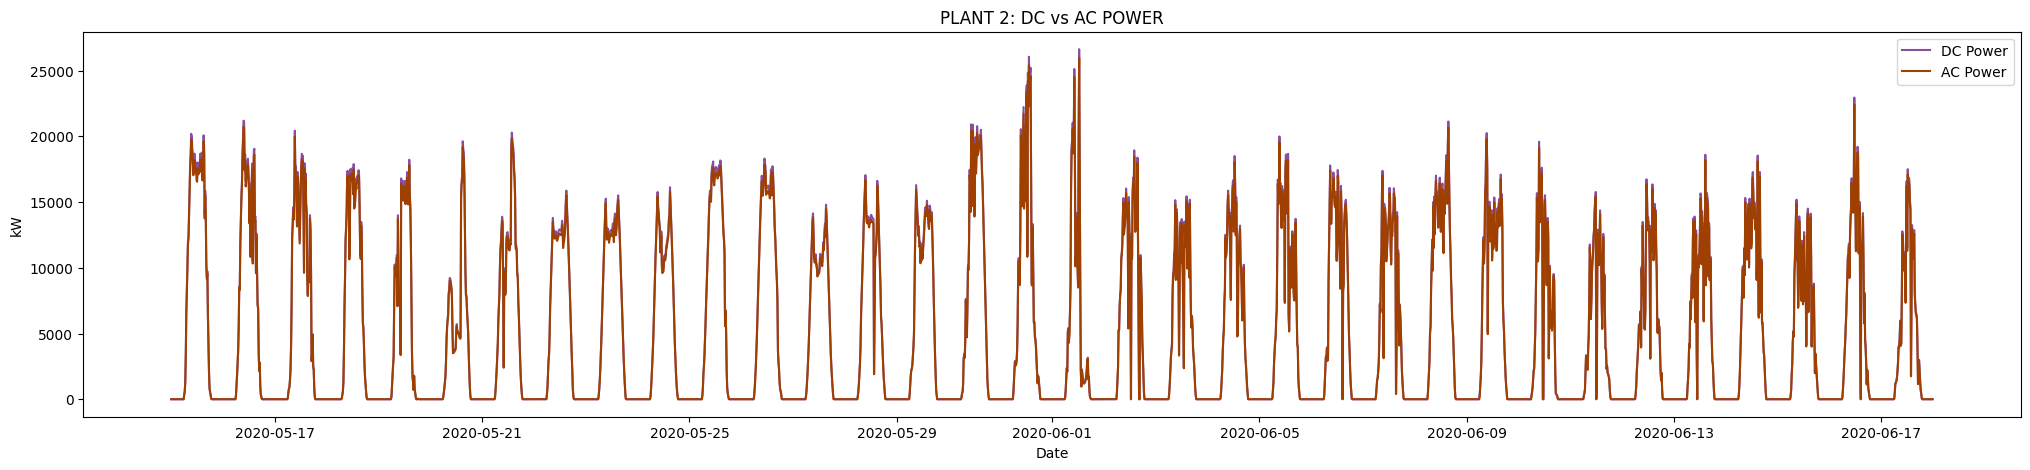

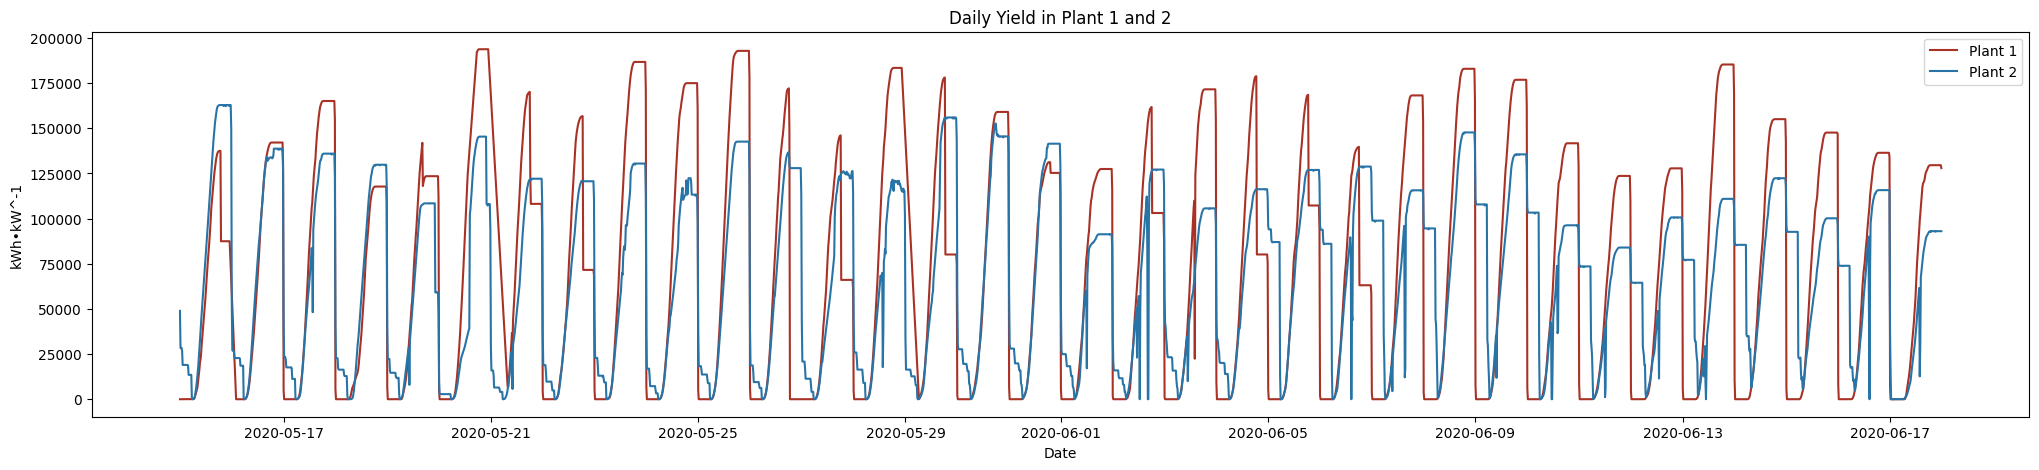

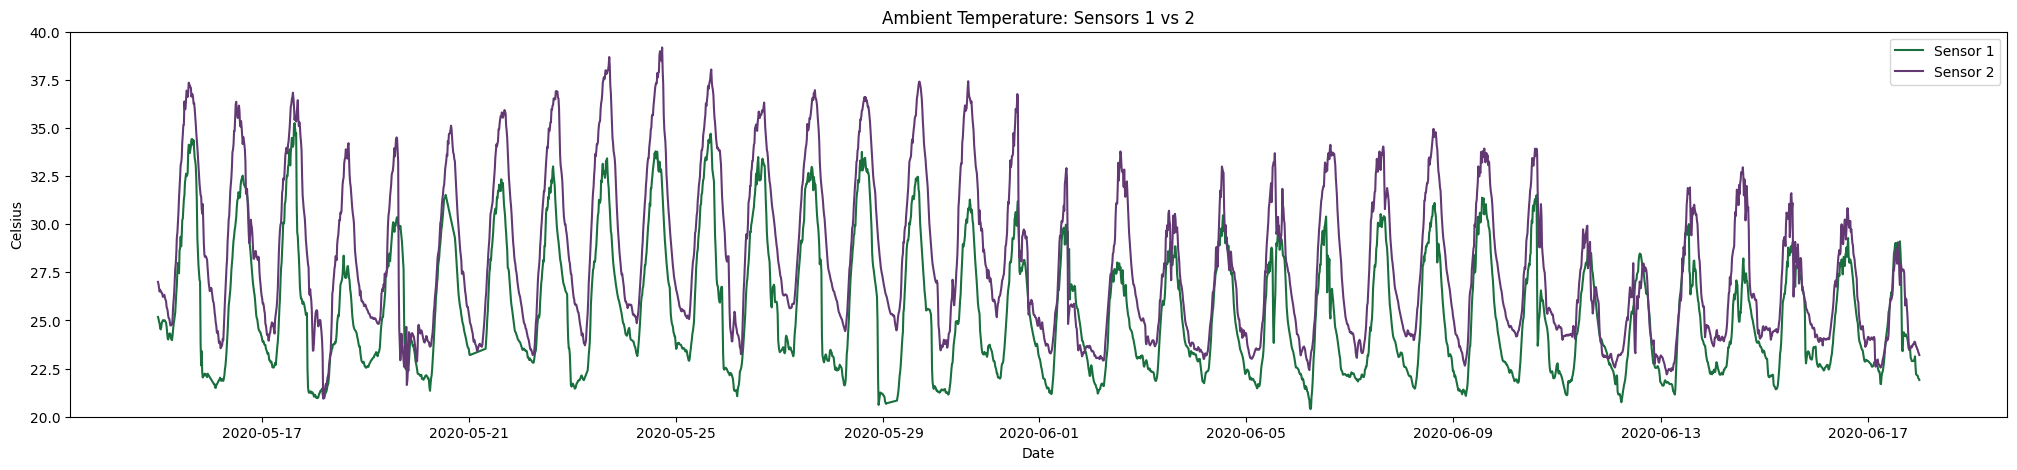

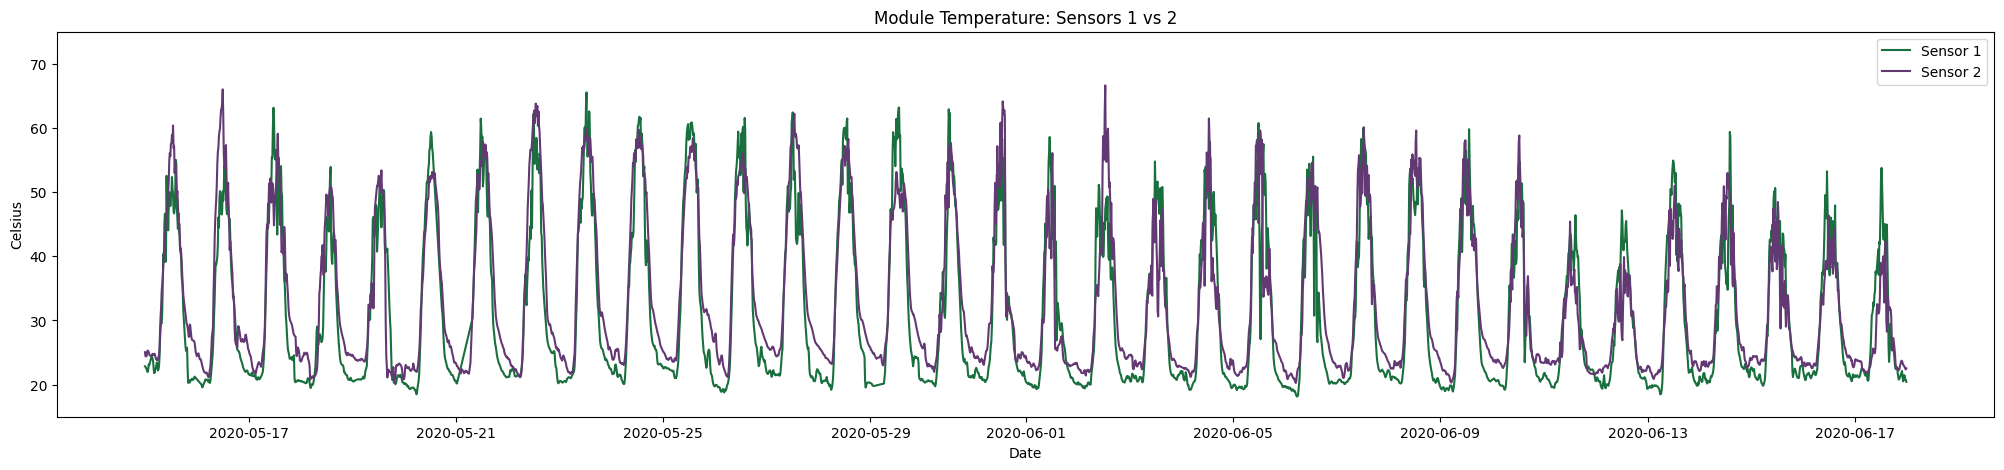

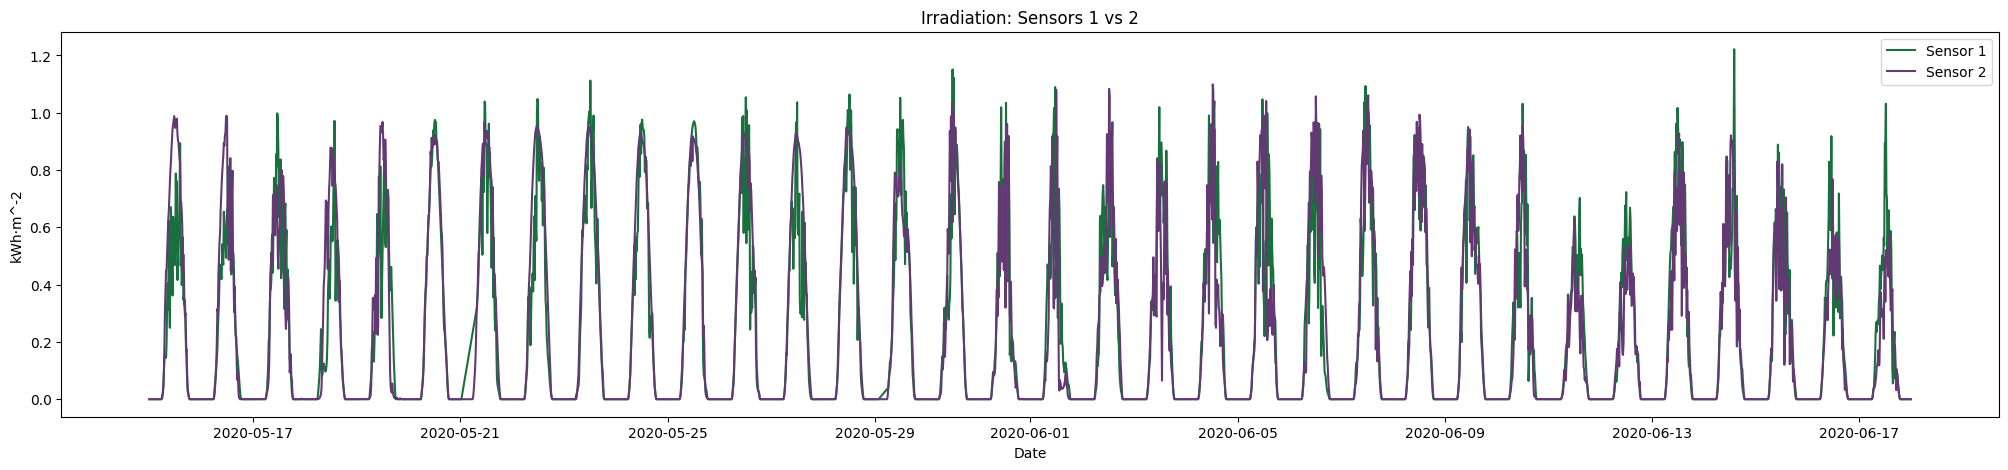

In [9]:
# --------- Visualisation --------- #

# Plant 1

plt.figure(figsize = (25,5))
plt.plot(gen1_idx['DATE_TIME'], gen1_idx['DC_POWER'], color = '#884ea0', label = 'DC POWER')
plt.plot(gen1_idx['DATE_TIME'], gen1_idx['AC_POWER'], color = '#a04000', label = 'AC POWER')
plt.title('PLANT 1: DC vs AC POWER')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend(['DC Power', 'AC Power'])

gen1_acdc_desc = str('Between the DC and AC records in plant 1, there is a discrepancy in power output by a factor of 10 in DC output.')
print(gen1_acdc_desc)

# Plant 2

fig, ax = plt.subplots(1, 2, figsize = (25,5))

ax[0].plot(gen2_idx['DATE_TIME'], gen2_idx['DC_POWER'], color = '#884ea0')
ax[0].set_title('DC POWER: PLANT 2')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('kW')
ax[0].tick_params(axis = 'x', rotation = 25)

ax[1].plot(gen2_idx['DATE_TIME'], gen2_idx['AC_POWER'], color = '#a04000')
ax[1].set_title('AC POWER: PLANT 2')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('kW')
ax[1].tick_params(axis = 'x', rotation = 25)

plt.tight_layout()
plt.show()

plt.figure(figsize = (25,5))
plt.plot(gen2_idx['DATE_TIME'], gen2_idx['DC_POWER'], color = '#884ea0', label = 'DC POWER')
plt.plot(gen2_idx['DATE_TIME'], gen2_idx['AC_POWER'], color = '#a04000', label = 'AC POWER')
plt.title('PLANT 2: DC vs AC POWER')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend(['DC Power', 'AC Power'])

gen2_acdc_desc = str('There is no discrepancy between AC and DC power outputs in Plant 2.')
print(gen2_acdc_desc)

# Daily Yield

plt.figure(figsize = (25,5))
plt.plot(gen1_idx.iloc[:,0], gen1_idx.iloc[:,5], color = '#a93226')
plt.plot(gen2_idx.iloc[:,0], gen2_idx.iloc[:,5], color = '#2874a6')
plt.title('Daily Yield in Plant 1 and 2')
plt.legend(['Plant 1', 'Plant 2'])
plt.xlabel('Date')
plt.ylabel('kWh•kW^-1')

# Ambient Temperature

plt.figure(figsize=(25,5))
plt.plot(sen1.iloc[:,0], sen1.iloc[:,3], color = '#196f3d')
plt.plot(sen2.iloc[:,0], sen2.iloc[:,3], color = '#633974')
plt.title('Ambient Temperature: Sensors 1 vs 2')
plt.legend(['Sensor 1', 'Sensor 2'])
plt.xlabel('Date')
plt.ylabel('Celsius')
plt.ylim([20.0,40.0])

# Module Temperature

plt.figure(figsize=(25,5))
plt.plot(sen1.iloc[:,0], sen1.iloc[:,4], color = '#196f3d')
plt.plot(sen2.iloc[:,0], sen2.iloc[:,4], color = '#633974')
plt.title('Module Temperature: Sensors 1 vs 2')
plt.legend(['Sensor 1', 'Sensor 2'])
plt.xlabel('Date')
plt.ylabel('Celsius')
plt.ylim([15.0,75.0])

# Irradiation

plt.figure(figsize=(25,5))
plt.plot(sen1.iloc[:,0], sen1.iloc[:,5], color = '#196f3d')
plt.plot(sen2.iloc[:,0], sen2.iloc[:,5], color = '#633974')
plt.title('Irradiation: Sensors 1 vs 2')
plt.legend(['Sensor 1', 'Sensor 2'])
plt.xlabel('Date')
plt.ylabel('kWh⋅m^-2')

### Statistical Testing

In [10]:
# -------------------------- Statistical testing -------------------------- #

# t-test to compare daily yield in plant 1 & 2

stats.ttest_ind(gen1.iloc[:,5], gen2.iloc[:,5], alternative='two-sided', equal_var=True)

# t-test to compare sensor 1 & 2 measurements: ambient temp, module temp, irradiation

## ambient temperature
stats.ttest_ind(sen1.iloc[:,3], sen2.iloc[:,3], alternative='two-sided', equal_var=True)

# ## module temp
stats.ttest_ind(sen1.iloc[:,4], sen2.iloc[:,4], alternative='two-sided', equal_var=True)

## irradiation
stats.ttest_ind(sen1.iloc[:,5], sen2.iloc[:,5], alternative='two-sided', equal_var=True)

ttest_res_sen = str('An independent t-test was conducted to investigate the difference in measurements between the two plants and sensors.'
                    '\nThe alpha level was set to 0.05, which shows us the probability to observe a falsely significant result.'
                    '\nThere is no statistical significant difference in daily yield (T = 0.066, p = 0.948) and irradiation (T = -0.578, p = 0.563) between Sensor 1 and 2, nor is there a difference in daily yield (T = 0.065, p = 0.948).'
                    '\nHowever, both the ambient and module temperatures of Sensor 2 are signficiantly greater than Sensor 1 (T = -27.306, p <  0.001; T = -5.715, p < 0.001).'
                    '\nThe difference in ambient temperatures could suggest that a maintenance and cleaning check on the sensors. \nNonetheless, more information and testing is required to assess the soiling ratio of the sensors.')

print(ttest_res_sen)

An independent t-test was conducted to investigate the difference in measurements between the two plants and sensors.
The alpha level was set to 0.05, which shows us the probability to observe a falsely significant result.
There is no statistical significant difference in daily yield (T = 0.066, p = 0.948) and irradiation (T = -0.578, p = 0.563) between Sensor 1 and 2, nor is there a difference in daily yield (T = 0.065, p = 0.948).
However, both the ambient and module temperatures of Sensor 2 are signficiantly greater than Sensor 1 (T = -27.306, p <  0.001; T = -5.715, p < 0.001).
The difference in ambient temperatures could suggest that a maintenance and cleaning check on the sensors. 
Nonetheless, more information and testing is required to assess the soiling ratio of the sensors.


### Performance Ratio

In [11]:
# --------------------------- Performance Ratio -------------------------- #
"""
Performance ratio assesses the PV panel system, taking into account temperature, soiling, etc.
To do this we're diving the actual energy output - AC, by the expected energy output in ideal conditions.
Formula: PR = (AC power / (Irradiation * Module temp)) * 100

First let's concat the two dataframes of each plant.
"""

merged_power = pd.concat([gen1_idx, gen2_idx])

merged_sensors = pd.concat([sen1, sen2])

all_dat = pd.merge(merged_power, merged_sensors, on=['DATE_TIME', 'PLANT_ID'])

PR = (sum(merged_power['AC_POWER'])/( sum(merged_sensors['IRRADIATION'])*( sum(merged_sensors['MODULE_TEMPERATURE']))))*100

print(f'The performance ratio for the system is {round(PR, 3)}%.')

The performance ratio for the system is 12.276%.


### Conversion Efficiency

In [12]:
# -------------------------------- Conversion Efficiency --------------------------- #

"""
Now we'll look at how efficient the AC power is converted into DC power in each plant. (AC/DC)*100
Recall that in Plant 1, DC had a 10 factor discrepancy to AC.
"""

CE_1 = (sum(gen1_idx['AC_POWER']) / (sum(gen1_idx['DC_POWER']/10))) * 100
CE_2 = (sum(gen2_idx['AC_POWER']) / (sum(gen2_idx['DC_POWER']))) * 100

print(f'The conversion efficiency in Plant 1 is {round(CE_1, 3)}%, and {round(CE_2, 3)}% in Plant 2.')

The conversion efficiency in Plant 1 is 97.795%, and 97.801% in Plant 2.


### Correlation Matrix

DC Power has a strong correlation with Irradiation (r = 0.91) and Module temperature (r = 0.87), and a medium correlation with ambient temperature (r = 0.65).
We will use these variables to predict DC power output later on.
Interestingly, there is a weak negative correlation observed in Daily Yield and DC Power (r = -0.11).


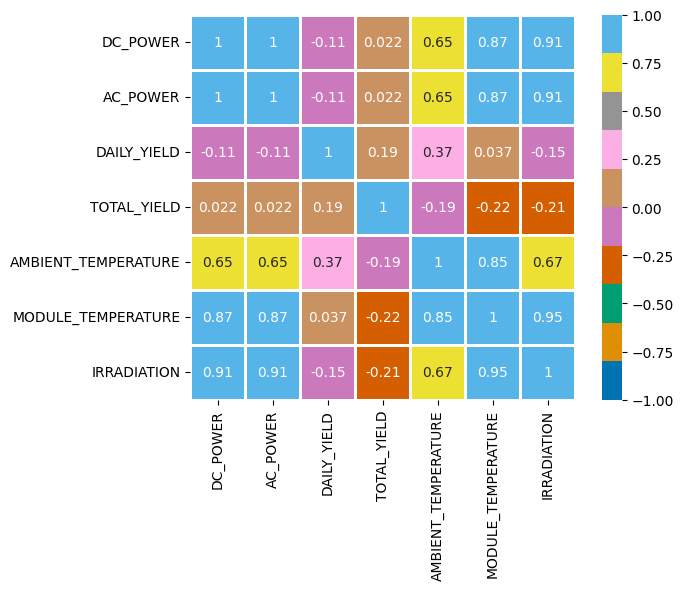

In [13]:
# ------------------------------ Correlation Matrix ----------------------- #

df_corr = pd.merge(gen2_idx, sen2, on = ['DATE_TIME', 'PLANT_ID'])
df_corr = df_corr.drop(['SOURCE_KEY_x', 'SOURCE_KEY_y', 'DATE_TIME', 'PLANT_ID'], axis=1)

matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(matrix,
    cmap=sns.color_palette('colorblind'),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax,
    linewidths=1, linecolor = 'white',
    annot=True)

nl = '\n'
print(f'DC Power has a strong correlation with Irradiation (r = 0.91) and Module temperature (r = 0.87), and a medium correlation with ambient temperature (r = 0.65).{nl}We will use these variables to predict DC power output later on.{nl}Interestingly, there is a weak negative correlation observed in Daily Yield and DC Power (r = -0.11).')


### Stationarity

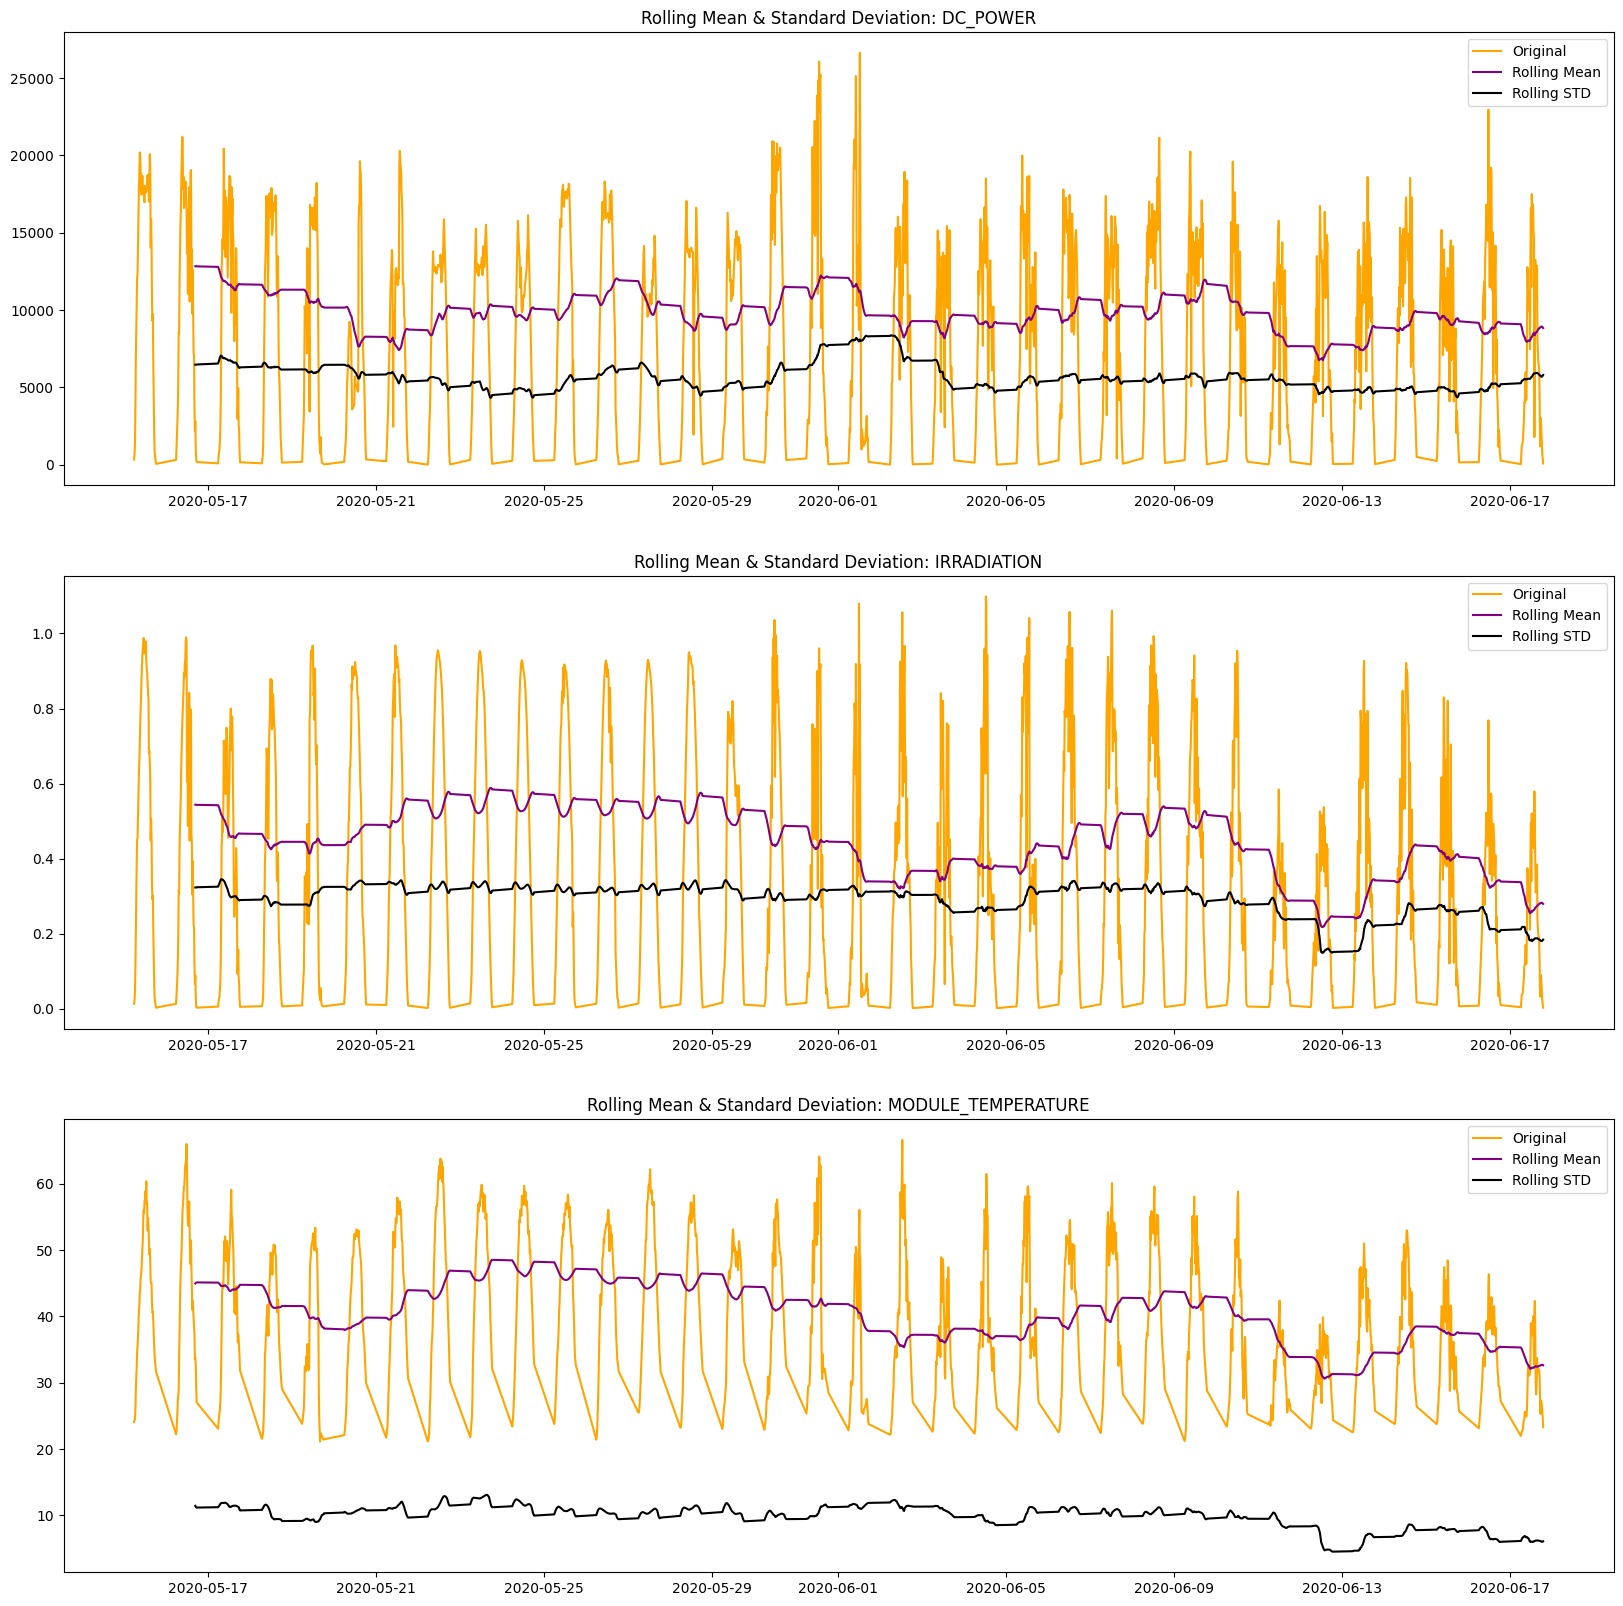

In [14]:
# ---------------------- Stationarity Check ------------------- #

df_rolling = pd.merge(gen2_idx, sen2, on = ['DATE_TIME', 'PLANT_ID'])

dropcols = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'PLANT_ID', 'SOURCE_KEY_x', 'SOURCE_KEY_y']

# set time to index, or else it won't work.
df_rolling = df_rolling.set_index('DATE_TIME')
df_rolling = df_rolling.drop(dropcols, axis=1)

# drop rows with 0.0 values
df_rolling = df_rolling.loc[(df_rolling!=0).all(axis=1)]

# Rolling statistics
rolling_avg = df_rolling.rolling(96).mean()
rolling_std = df_rolling.rolling(96).std()

# Plot rolling stats
fig, ax = plt.subplots(3, 1, figsize = (20,20))

variables = ['DC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']

for ii in range(len(variables)):

    ax[ii].plot(df_rolling[variables[ii]], color='orange',label='Original')
    ax[ii].plot(rolling_avg[variables[ii]], color='purple', label='Rolling Mean')
    ax[ii].plot(rolling_std[variables[ii]], color='black', label = 'Rolling STD')

    ax[ii].legend(loc='best')
    ax[ii].set_title(f'Rolling Mean & Standard Deviation: {variables[ii]}')

plt.show(block=False)

# Forecasting

## Exploration

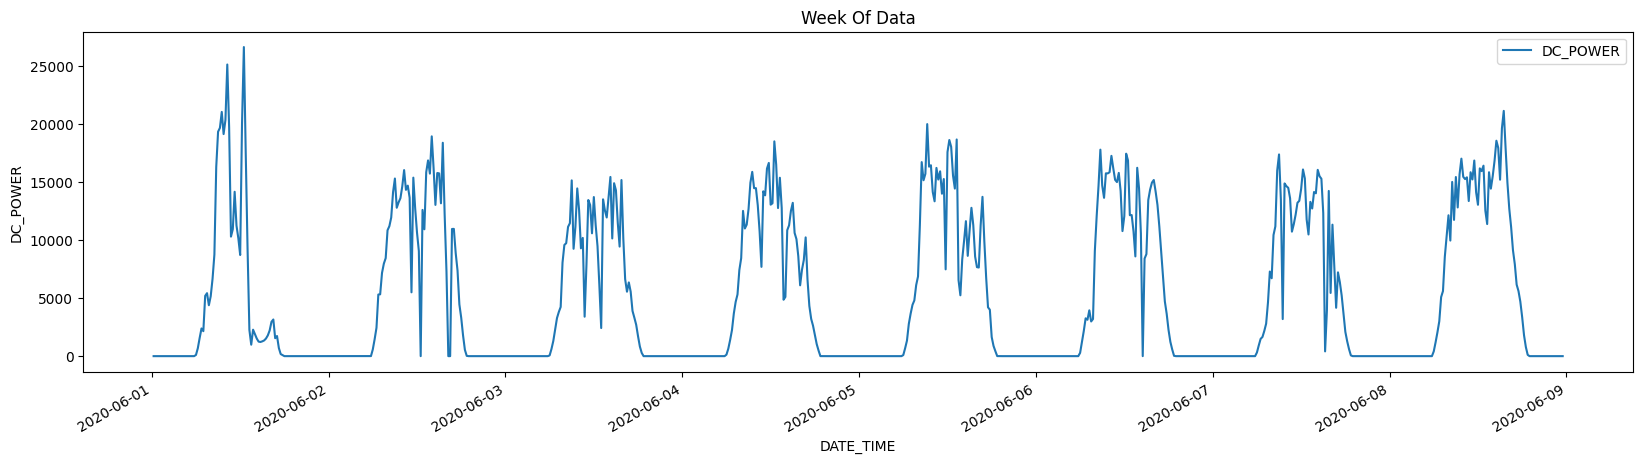

"\nTwo things of note:\n\n1. There seems to be multiple peaks during the day\n2. There are periods of zero activity at the start and end of the day - which is normal, due to the sunrise and sunset.\n\nLet's look at the data hourly during the day.\n"

In [15]:
# -------------------------- Forecasting ---------------------- #

"""
Model DC Power from time, module temperature, irradiation
"""

# Take a look at a week's data first

dc_df = pd.DataFrame(gen2_idx[['DATE_TIME','DC_POWER']])
dc_df = dc_df.set_index('DATE_TIME')

dc_df.loc[(dc_df.index > '2020-06-01 00:00:00') & (dc_df.index < '2020-06-08 23:45:00')].plot(figsize=(20, 5), title='Week Of Data')
plt.ylabel('DC_POWER')
plt.show()

"""
Two things of note:

1. There seems to be multiple peaks during the day
2. There are periods of zero activity at the start and end of the day - which is normal, due to the sunrise and sunset.

Let's look at the data hourly during the day.
"""

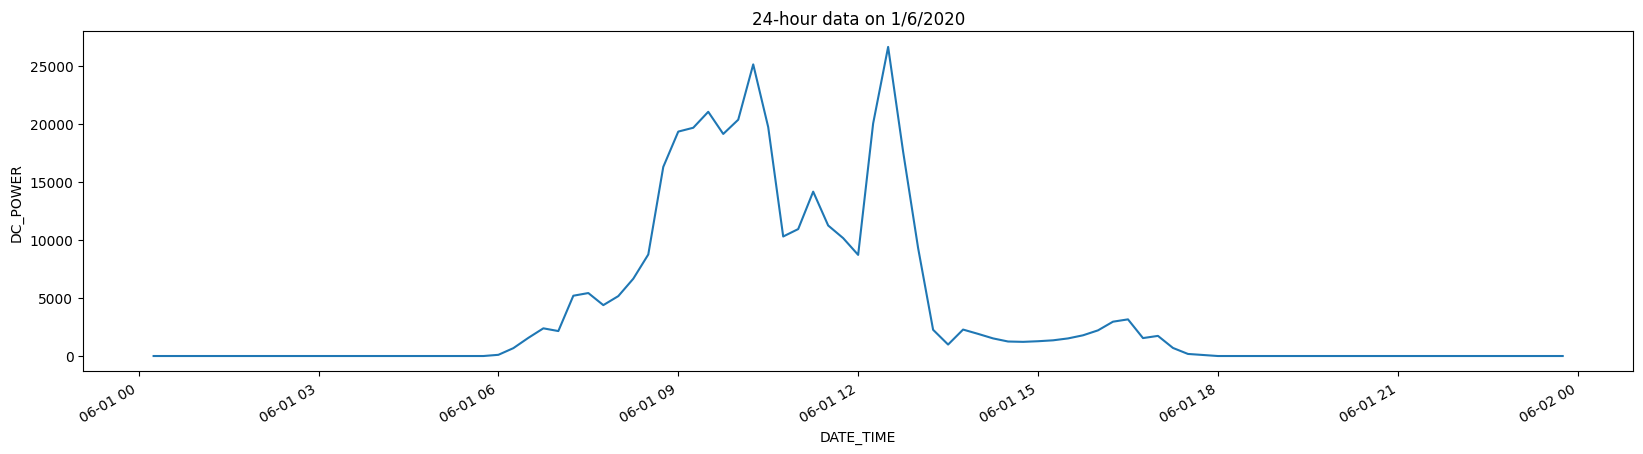

In [16]:
dc_df['hour'] = dc_df.index.hour

# Data of 1 day

dc_df['DC_POWER'].loc[(dc_df.index > '2020-06-01 00:00:00') & (dc_df.index < '2020-06-02 00:00:00')].plot(figsize = (20,5), title = '24-hour data on 1/6/2020')
plt.ylabel('DC_POWER')
plt.show()

## Supervised

In [17]:
# ---------- create features: we want to predict dc power by time, module temperature and irradiation

testing_df = pd.DataFrame(gen2_idx[['DATE_TIME','DC_POWER']])
testing_df = testing_df.merge(sen2[['MODULE_TEMPERATURE', 'IRRADIATION']], how = 'left', left_index=True, right_index=True)
testing_df['TIME'] = np.arange(len(testing_df))
testing_df = testing_df.set_index('DATE_TIME')

features2 = ['TIME', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = ['DC_POWER']  

split_dat2 = train_test_split(testing_df, .80) # 80-20 ratio
train2 = split_dat2[0]
test2 = split_dat2[1]

X_train2 = train2[features2]
y_train2 = train2[target]

X_test2 = test2[features2]
y_test2 = test2[target]

Total records:  3259
Training records:  2607
Testing records:  652


### Seasonal ARIMA
Autoregressive Integrated Moving Average (ARIMA) is one of the most common methods of timeseries data.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable.
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation.
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

Let's look at the performance of ARIMA then compare it to Seasonal ARIMA.

In [21]:
# use auto_arima() to define (p,d,q) parameters
auto_arima(y_train2['DC_POWER'], test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=46603.092, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53294.025, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46611.406, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50598.199, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54560.450, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=46607.247, Time=0.64 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46616.034, Time=1.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=46604.671, Time=2.66 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=46594.517, Time=3.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=46594.807, Time=0.73 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=46598.823, Time=4.21 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=46588.965, Time=5.28 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=46590.874, Time=1.10 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=46569.112, Time=7.27 sec
 ARIMA(4,0,4)(0,0,0

ARIMA(order=(2, 0, 5), scoring_args={}, suppress_warnings=True)

In [29]:
# find d
auto_arima(testing_df['DC_POWER'], test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=31883.957, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34763.956, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=31896.946, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33354.242, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37023.344, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=31888.655, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=31890.409, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=31870.292, Time=2.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=31880.674, Time=0.74 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=31870.104, Time=2.64 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=31858.420, Time=1.19 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=31863.558, Time=1.82 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=31848.139, Time=3.18 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=31853.063, Time=0.71 sec
 ARIMA(5,0,2)(0,0,0

ARIMA(order=(5, 0, 1), scoring_args={}, suppress_warnings=True)

In [30]:
# Build ARIMA model

model=ARIMA(y_train2['DC_POWER'], order=(1,0,0)).fit()
model.summary()

/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               DC_POWER   No. Observations:                 2607
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -23302.706
Date:                Wed, 16 Oct 2024   AIC                          46611.412
Time:                        18:33:16   BIC                          46629.010
Sample:                             0   HQIC                         46617.788
                               - 2607                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5260.4546   1488.704      3.534      0.000    2342.648    8178.262
ar.L1          0.9606      0.008    126.782      0.000       0.946       0.975
sigma2      3.397e+06   4.11e+04     82.609      0.000    3.32e+06    3.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):             22833.22
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.52   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
# THIS STEP IS CRUCIAL TO MAINTAIN THE SAME DATE_TIME IN THE PREDICTION (otherwise it will show a different date-time like 1970 on the plot...)

time_index = testing_df.reset_index()[['DATE_TIME']]

pred= model.predict(start=len(X_train2['IRRADIATION']), end=(len(testing_df['IRRADIATION'])-1),dynamic=True)

arima_testing_df = testing_df.copy()

pred_df = pd.DataFrame(pred)
pred_df = pred_df.join(time_index)
pred_df = pred_df.set_index(['DATE_TIME'])
pred_df = pred_df.join(arima_testing_df)
pred_df

/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean,DC_POWER,MODULE_TEMPERATURE,IRRADIATION,TIME
DATE_TIME,,,,,
2020-06-11 05:00:00,207.052461,0.000000,23.144594,0.000000,2607
2020-06-11 05:15:00,405.955300,0.000000,23.236198,0.000000,2608
2020-06-11 05:30:00,597.029286,0.000000,23.634012,0.000000,2609
2020-06-11 05:45:00,780.582565,0.000000,23.681646,0.000255,2610
2020-06-11 06:00:00,956.911153,16.074762,23.726226,0.004264,2611
...,...,...,...,...,...
2020-06-17 22:45:00,5260.454603,0.000000,22.856201,0.000000,3254
2020-06-17 23:00:00,5260.454603,0.000000,22.744190,0.000000,3255
2020-06-17 23:15:00,5260.454603,0.000000,22.492245,0.000000,3256


In [170]:
# Model Evaluation: Mean Absolute Percentage Error (MAPE):
## MAPE is defined as the percentage of the average of absolute difference between forecasted values and true values, divided by true value.
## Lower the MAPE value, the better.

mape= mean_absolute_percentage_error(y_test2['DC_POWER'], pred_df['predicted_mean'])

print('MAPE: %f' %mape)

MAPE: 10456691915502116864.000000


The MAPE value is very high - let's plot the predicted value to see the reason for low accuracy.

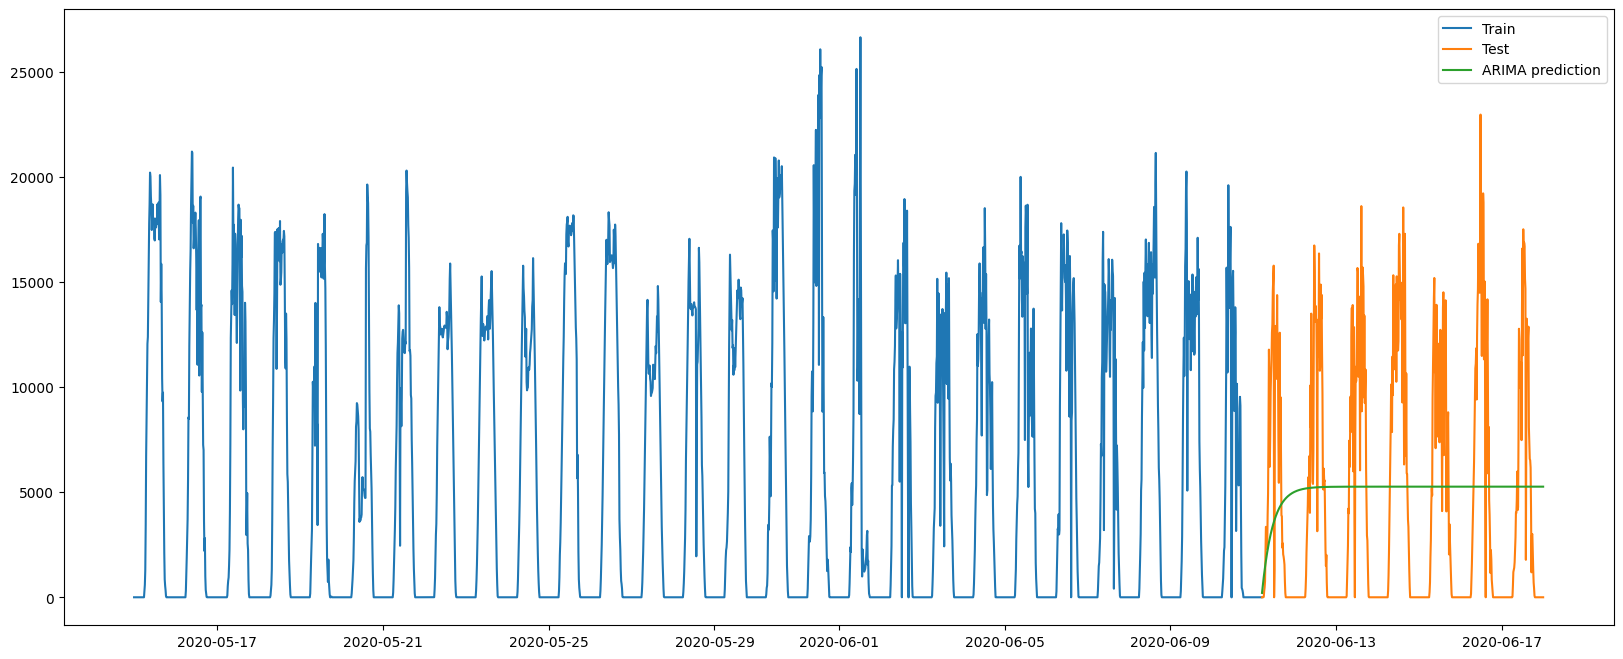

In [171]:
plt.figure(figsize = (20,8))

plt.plot(y_train2['DC_POWER'],label='Train')
plt.plot(y_test2['DC_POWER'], label= 'Test')
plt.plot(pred_df['predicted_mean'], label='ARIMA prediction')

plt.legend()

The model is missing seasonality - let's now use Seasonal ARIMA to see how it compares.

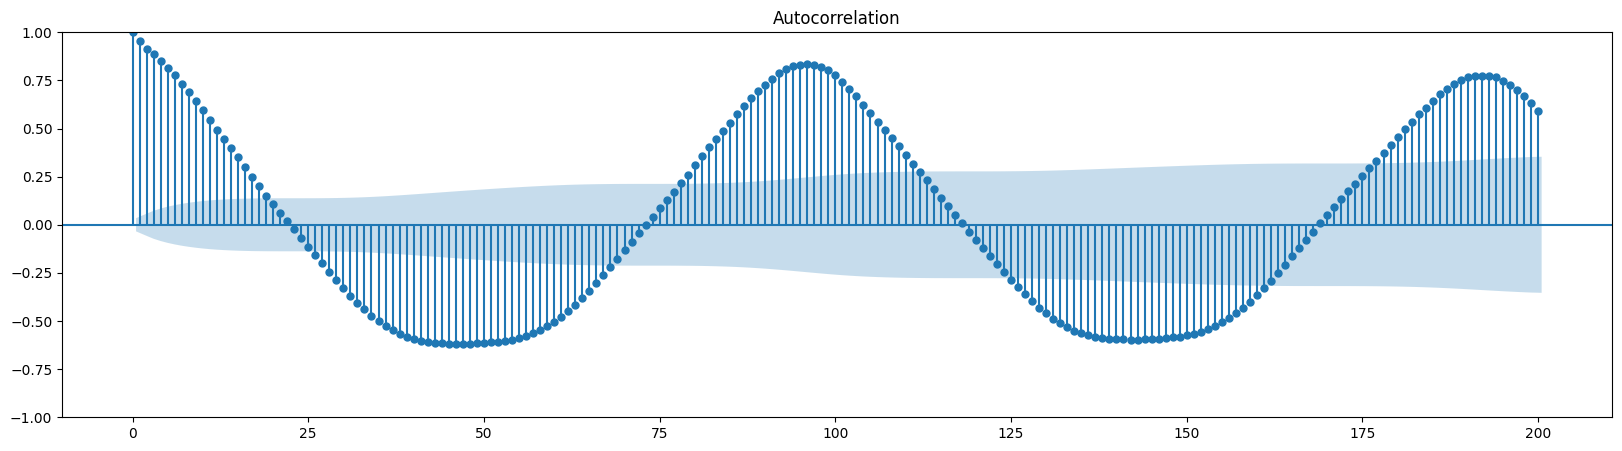

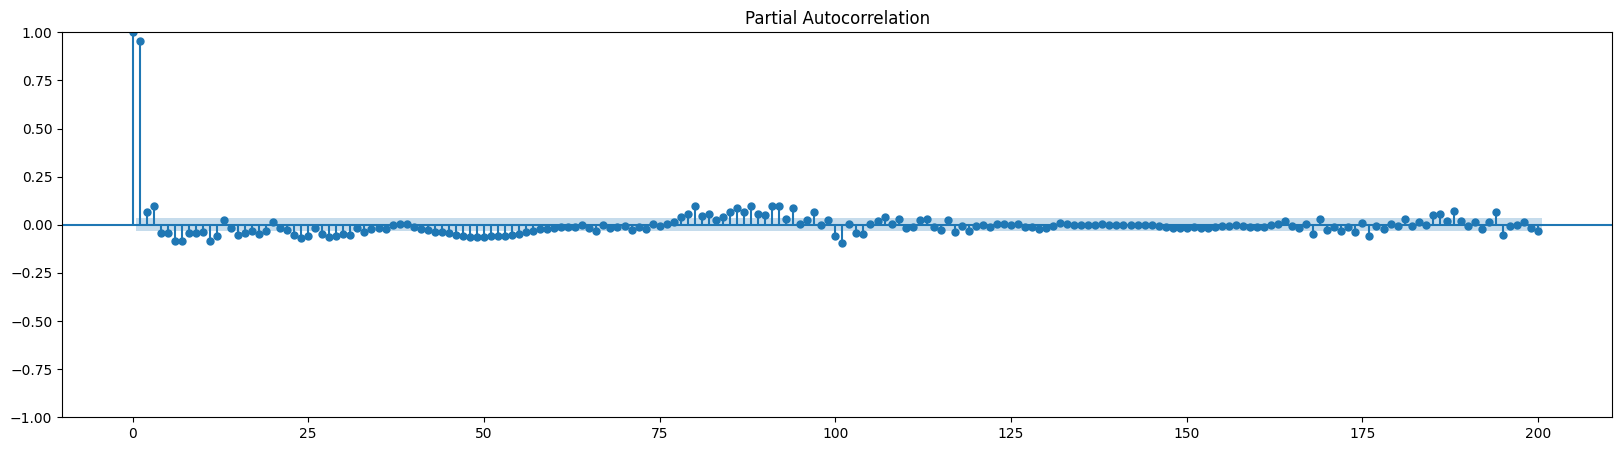

In [91]:
# Find m value for seasonal period: use autocorrelation ACF

f_acf = plot_acf(testing_df['DC_POWER'], lags=200)
f_pacf = plot_pacf(testing_df['DC_POWER'], lags=200, method='ols')

f_acf.set_figheight(5)
f_acf.set_figwidth(20)

f_pacf.set_figheight(5)
f_pacf.set_figwidth(20)
plt.show()

From the ACF, the greatest autocorrelation value is 50, so we'll set the seasonal order period to 50.

In [39]:
model1=sm.tsa.statespace.SARIMAX(y_train2['DC_POWER'],order=(0,0,2),exog=None,seasonal_order=(3,0,0,50))

results=model1.fit(method='cg') # avoid 'the problem is unconstrained' error
results.summary()

/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            DC_POWER   No. Observations:                 2607
Model:             SARIMAX(0, 0, 2)x(3, 0, [], 50)   Log Likelihood              -26172.674
Date:                             Wed, 16 Oct 2024   AIC                          52357.349
Time:                                     18:45:23   BIC                          52392.544
Sample:                                          0   HQIC                         52370.099
                                            - 2607                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9508      0.015     63.542      0.000       0.921       0.980
ma.L2          0.8646      0.014     62.874      0.000       0.838       0.892
ar.S.L50      -0.0351      0.313     -0.112      0.911      -0.648       0.578
ar.S.L100      0.8599      0.028     30.317      0.000       0.804       0.916
ar.S.L150      0.0393      0.286      0.138      0.891      -0.521       0.599
sigma2      6.644e+07   6.44e-09   1.03e+16      0.000    6.64e+07    6.64e+07
===================================================================================
Ljung-Box (L1) (Q):                 170.88   Jarque-Bera (JB):              5886.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+31. Standard errors may be unstable.
"""

In [162]:
pred_sarimax = results.predict(start = len(y_train2['DC_POWER']), end = (len(testing_df['DC_POWER'])-1), dynamic=True)

new_testing_df = testing_df.copy()

pred_sarimax_df = pd.DataFrame(pred_sarimax)
pred_sarimax_df = pred_sarimax_df.join(time_index)
pred_sarimax_df = pred_sarimax_df.set_index(['DATE_TIME'])
pred_sarimax_df = pred_sarimax_df.join(new_testing_df)
pred_sarimax_df
# .loc[2607:3258,:]

/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean,DC_POWER,MODULE_TEMPERATURE,IRRADIATION,TIME
DATE_TIME,,,,,
2020-06-11 05:00:00,-190.815856,0.000000,23.144594,0.000000,2607
2020-06-11 05:15:00,298.288930,0.000000,23.236198,0.000000,2608
2020-06-11 05:30:00,482.397409,0.000000,23.634012,0.000000,2609
2020-06-11 05:45:00,598.246236,0.000000,23.681646,0.000255,2610
2020-06-11 06:00:00,507.936039,16.074762,23.726226,0.004264,2611
...,...,...,...,...,...
2020-06-17 22:45:00,2047.017557,0.000000,22.856201,0.000000,3254
2020-06-17 23:00:00,3123.520475,0.000000,22.744190,0.000000,3255
2020-06-17 23:15:00,3311.993057,0.000000,22.492245,0.000000,3256


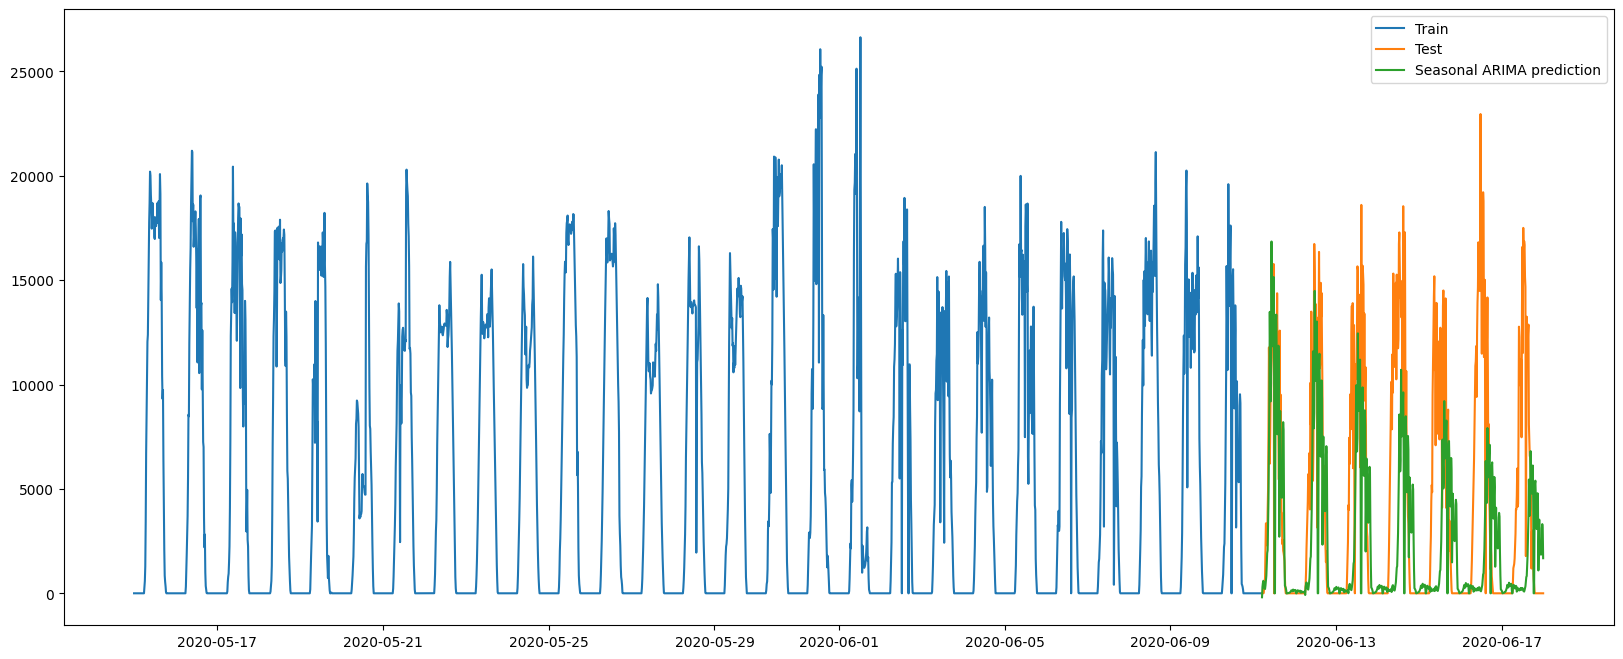

In [163]:
# Plot SARIMAX prediction

plt.figure(figsize = (20,8))

plt.plot(y_train2['DC_POWER'],label='Train')
plt.plot(y_test2['DC_POWER'], label= 'Test')
plt.plot(pred_sarimax_df['predicted_mean'], label='Seasonal ARIMA prediction')

plt.legend()


In [165]:
from sklearn import metrics
from sklearn.metrics import r2_score

r2_sarimax = r2_score(y_test2, pred_sarimax_df['predicted_mean'])

print(f'Accuracy: {r2_sarimax*100}%')

Accuracy: -0.6850504696454651%


It seems that the predictions decrease with time - however this is the best the model can do.

Let's look at a different model to see if it's better for the data.

### XGBoost

[0]	validation_0-rmse:8395.24538	validation_1-rmse:7193.98995
[100]	validation_0-rmse:3584.82221	validation_1-rmse:3151.74978
[200]	validation_0-rmse:2168.57275	validation_1-rmse:2151.18332


/Users/madelinelui/opt/anaconda3/envs/PV-panels/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:54:14] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1749.94155	validation_1-rmse:1969.50685
[400]	validation_0-rmse:1605.23033	validation_1-rmse:1922.40230
[455]	validation_0-rmse:1562.49991	validation_1-rmse:1933.54675


/var/folders/ls/4941g_z961x8w3kw7_rdtgbh0000gn/T/ipykernel_81156/1137612017.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['prediction'] = reg.predict(X_test2)


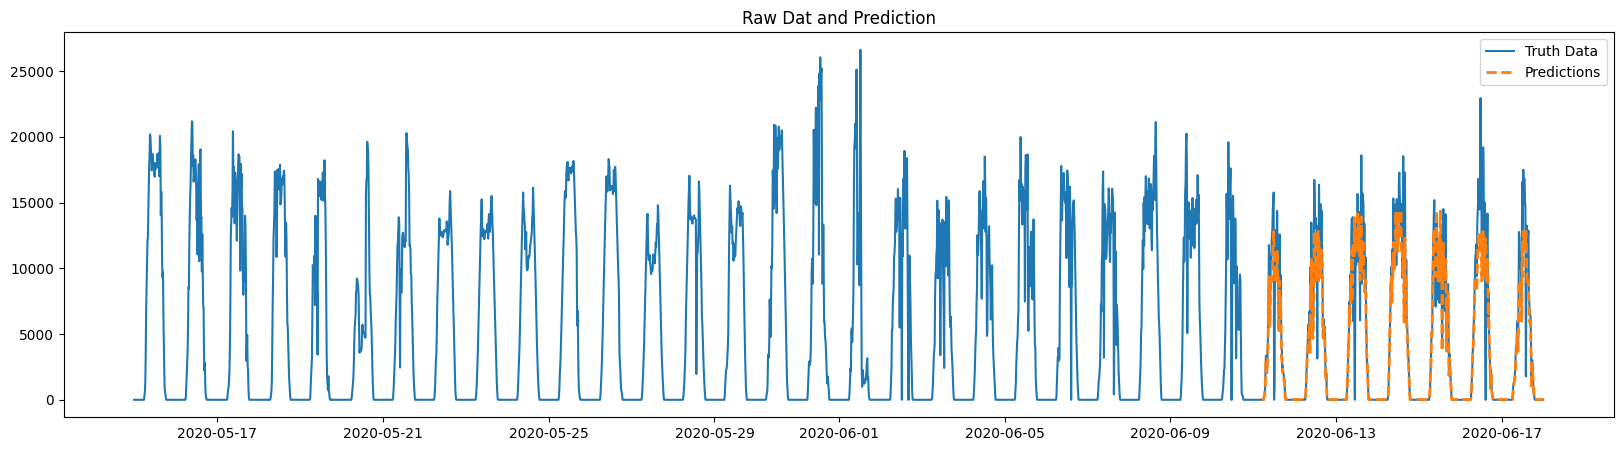

In [43]:
# ------- XGBOOST MODEL ---- #

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50, # stop early if the model gets worse, aka overfitting
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train2, y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        verbose=100) # show per every 100 iteration

# --------- Plot ground truth and Prediction

test2['prediction'] = reg.predict(X_test2)
testing_true_df = testing_df.merge(test2[['prediction']], how='left', left_index=True, right_index=True)
plt.figure(figsize = (20,5))
plt.plot(testing_true_df[['DC_POWER']])
plt.plot(testing_true_df[['prediction']], linestyle='--', linewidth = 2)
plt.legend(['Truth Data', 'Predictions'])
plt.title('Raw Dat and Prediction')
plt.show()

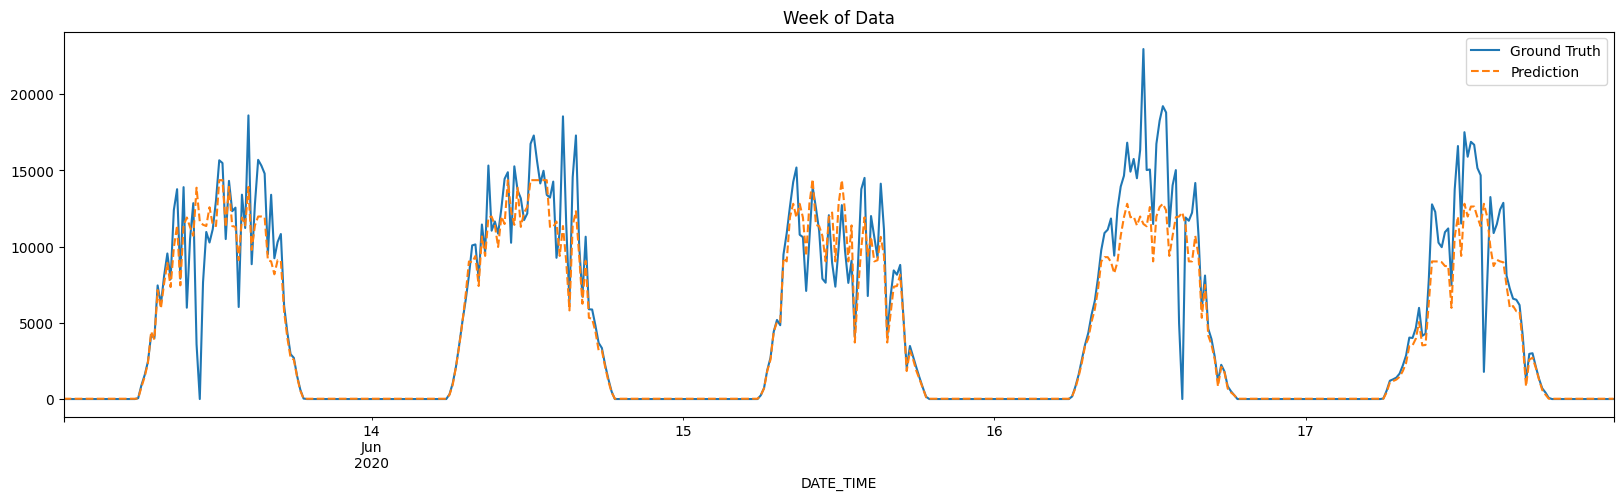

RMSE Score on Test set: 1921.08


In [44]:
# let's look at a week

ax = testing_true_df.loc[(testing_true_df.index > '2020-06-13 00:00:00') & (testing_true_df.index < '2020-06-21 23:45:00')]['DC_POWER'] \
    .plot(figsize = (20,5), title='Week of Data')
testing_true_df.loc[(testing_true_df.index > '2020-06-13 00:00:00') & (testing_true_df.index < '2020-06-21 23:45:00')]['prediction'] \
    .plot(style = '--')
plt.legend(['Ground Truth','Prediction'])
plt.show()

score2 = np.sqrt(mean_squared_error(test2['DC_POWER'], test2['prediction']))
print(f'RMSE Score on Test set: {score2:0.2f}')

In [45]:
# what times does the model predict the best / worst
test2['error'] = np.abs(test2['DC_POWER'] - test2['prediction'])
test2.groupby(test2.index)['error'].mean().sort_values(ascending=False).head(10)

/var/folders/ls/4941g_z961x8w3kw7_rdtgbh0000gn/T/ipykernel_81156/1134967338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['error'] = np.abs(test2['DC_POWER'] - test2['prediction'])


DATE_TIME
2020-06-16 14:30:00    12233.349609
2020-06-13 10:45:00    11633.313477
2020-06-16 11:30:00    11475.691888
2020-06-11 12:00:00    11332.134766
2020-06-17 13:45:00    11024.899933
2020-06-13 10:30:00    10265.141323
2020-06-12 13:00:00     8830.542768
2020-06-11 12:15:00     8663.619486
2020-06-14 14:45:00     7193.263034
2020-06-16 14:15:00     7009.140387
Name: error, dtype: float64

### Predicting the next 7 days

In [46]:
# ------- Future dates: 7 days

forecast_week = create_dates(7)
forecast_week['TIME'] = np.arange(start=3259, stop=3931, step=1)
forecast_week = forecast_week.set_index('DATE_TIME')

In [47]:
# build lagged features
testing_and_forecast = pd.concat([testing_df, forecast_week], axis=0)

forecast_lag_var = create_lag_features(testing_and_forecast)

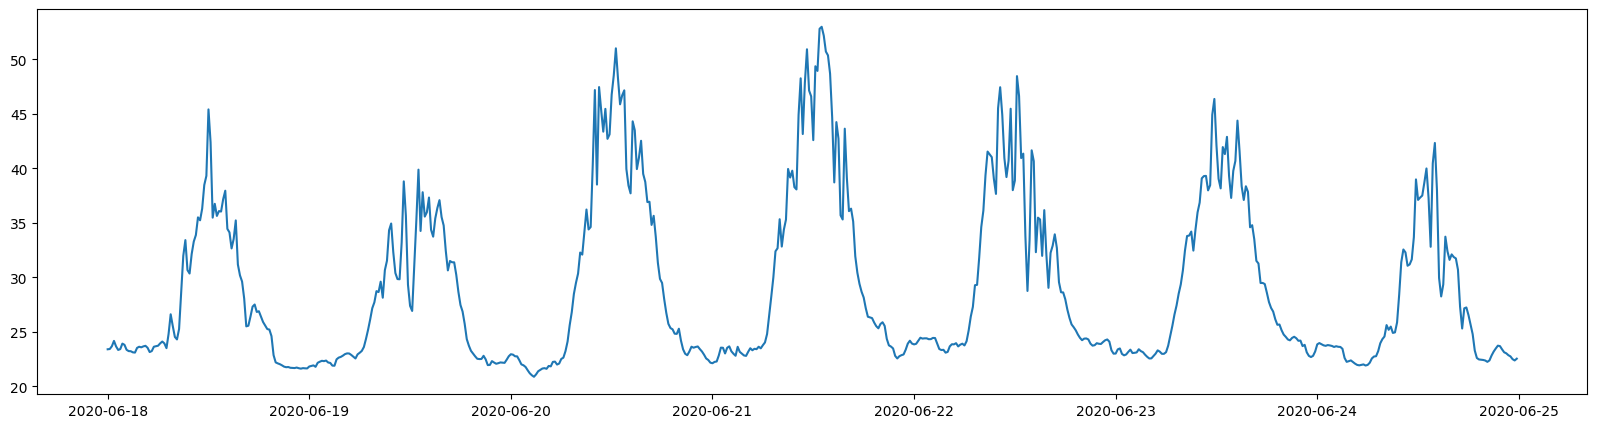

In [48]:
plt.figure(figsize=(20,5))
plt.plot(forecast_lag_var['MODULE_TEMPERATURE'])

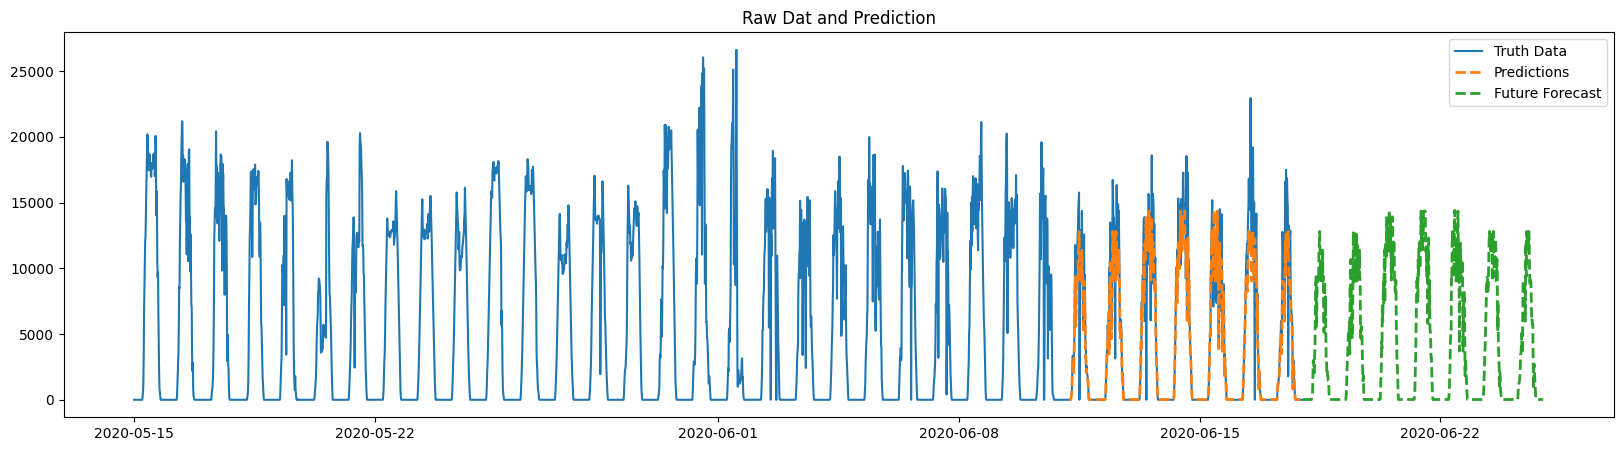

In [49]:
# reorder columns to match the training df
forecast_lag_var = forecast_lag_var[['TIME', 'MODULE_TEMPERATURE', 'IRRADIATION']]

# give prediction values based on lagged features
forecast_lag_var['prediction'] = reg.predict(forecast_lag_var)

plt.figure(figsize = (20,5))
plt.plot(testing_true_df[['DC_POWER']])
plt.plot(testing_true_df[['prediction']], linestyle='--', linewidth = 2)
plt.plot(forecast_lag_var[['prediction']], linestyle='--', linewidth=2)
plt.legend(['Truth Data', 'Predictions', 'Future Forecast'])
plt.title('Raw Dat and Prediction')
plt.show()


In [58]:

score = reg.score(X_test2, y_test2)
print("Accuracy: %.2f%%" % (score * 100.0))


Accuracy: 88.37%


The accuracy of the XGBoost model has increased by over 80%, compared to using the SARIMAX model.

There are other ways to improve the model, for example taking external data as features. This could include the weather forecast of future dates, focusing on variables such as irradiance. Another external data example would be the sunrise and sunset times across the relevant days and concerned future dates.